<a href="https://colab.research.google.com/github/bccp/DeepUQ/blob/master/ImageCorruptionMNIST_masknoise05_SVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Commented example of noisy masked 4 with comparison of EL2O with Stochastic Variational inference

In [292]:
import os
%pylab inline
import pickle
import time

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['rec', 'indices', 'seed', 'var']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [293]:
# for making nice plots of sampled posteriors
! pip install -q https://github.com/dfm/corner.py/archive/master.zip
import corner

     / 10.6MB 3.0MB/s


In [294]:
from google.colab import drive

ROOT = "/content/gdrive"
drive.mount(ROOT, force_remount=True)

PROJ = "My Drive/BDL2019_2" 
PROJECT_PATH = os.path.join(ROOT, PROJ)
print(PROJECT_PATH)

Mounted at /content/gdrive
/content/gdrive/My Drive/BDL2019_2


In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow.contrib.distributions import softplus_inverse

In [0]:
# pathes to trained generative models
generator_path   = os.path.join(PROJECT_PATH,'modules/decoder1/decoder')
encoder_path     = os.path.join(PROJECT_PATH,'modules/encoder1/encoder')
nvp_func_path    = os.path.join(PROJECT_PATH,'modules/nvp1/')
minima_path      = os.path.join(PROJECT_PATH,'minima/')
plot_path        = os.path.join(PROJECT_PATH,'plots/')

In [0]:
# functions to load mnist dataset
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test
  
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

Choose you settings

In [0]:
data_dim    = 28*28 # data dimensionality
data_size   = 1     # number of corrupted input data, always 1
sigma_n     = 0.1   # noise level used in the likelihood, determined during VAE training or measured
hidden_size = 10    # latent space dimensionality of the VAE
sample_size = 512   # number of samples drawn in each step of the ELBO minimization (for stochastic VI only)
n_channels  = 1     # mnist is b/w -> 1 channel
seed        = 777   # random seed

### choose one of the following to run different examples

# settings for reconstruction with uncorrupted data
# corr_type   = 'none'
# num_mnist   = 6
# label       = 'uncorrupted'
# noise_level = 0.0
# num_comp    = 2

# settings for reconstrcution with rectangular mask
# corr_type   = 'mask'
# num_mnist   = 6
# label       = 'solidmask'
# noise_level = 0.0
# num_comp    = 5

#settings for reconstruction with sparse mask 
# corr_type   = 'sparse mask'
# num_mnist   = 1
# label       = 'sparse95'
# noise_level = 0.
# num_comp    = 2

# settings for reconstruction with noise
# corr_type   = 'noise'
# num_mnist   = 6
# label       = 'noise05'
# noise_level = 0.5
# num_comp    = 2

# settings for reconstruction with noise and mask
corr_type   = 'noise+mask'
num_mnist   = 6
label       = 'masknoise05'
noise_level = 0.5
num_comp    = 3

In [0]:
plot_path = os.path.join(plot_path,'%s/'%label)

if not os.path.isdir(plot_path):
  os.makedirs(plot_path)

In [0]:
def plot_image(image, save=True, directory='./plots/',filename='plotted_image', title='image',vmin=None,vmax=None, mask=None):
  """
  plots and saves a single image of mnist format
  """
  
  if np.any(mask==None):
    mask=np.ones_like(image)
  mask = np.reshape(mask,(28,28))
  plt.figure()
  #plt.title(title)
  plt.imshow((image).reshape((28,28))*mask,cmap='gray',vmin=vmin, vmax=vmax)
  plt.axis('off')
  #plt.colorbar()
  if save: 
    plt.savefig(directory+filename+'.pdf',bbox_inches='tight')
  plt.show()
  
  return True

def get_custom_noise(shape, signal_dependent=False, signal =None, sigma_low=0.07, sigma_high=0.22, threshold=0.02 ):
  """
  adds the model error and the noise level in the data to obtain the total sigma that is used in the likelihood (option to make the reconstruction error signal dependent is not used) 
  """
  sigma = np.ones(shape)*sigma_n
  
  if signal_dependent: 
    for ii in range(data_size):
      sigma[ii][np.where(signal[ii]<=threshold)]= sigma_low
      sigma[ii][np.where(signal[ii]>threshold)]= sigma_high
      
  data_noise = np.ones_like(sigma)*noise_level
  
  sigma = np.sqrt(sigma**2+data_noise**2)
  
  return sigma
  

def make_corrupted_data(x_true, corr_type='mask'):
  """
  creates the corrupted image according to chosen corruption type
  """
  
  mask = np.ones((28,28))
  
  if corr_type=='mask':
    
    minx = 10
    maxx = 24
    
    mask[0:28,minx:maxx]=0.
    mask = mask.reshape((28*28))
    
    corr_data = x_true*[mask]
    
  elif corr_type=='sparse mask':
    
    mask    = np.ones(data_dim, dtype=int)
    percent = 95
    np.random.seed(seed+2)
    indices = np.random.choice(np.arange(data_dim), replace=False,size=int(percent/100.*data_dim))
    print('precentage masked:', len(indices)/data_dim)
    mask[indices] =0 
  
    corr_data = x_true*[mask]
    
  elif corr_type=='noise':
    
    np.random.seed(seed+2)
    noise = np.random.randn(data_dim*data_size)*noise_level
    
    corr_data = x_true+noise
    
  elif corr_type=='noise+mask':
    
    np.random.seed(seed+2)
    noise = np.random.randn(data_dim*data_size)*noise_level
    
    minx = 14
    maxx = 28
    
    mask[0:28,minx:maxx]=0.
    mask = mask.reshape((28*28))
    
    corr_data = x_true+noise
    corr_data = corr_data*[mask]
    
  elif corr_type=='none':
    
    corr_data = x_true
    
  corr_data = np.expand_dims(corr_data,-1)
  
  mask = mask.flatten()
  
  return corr_data, mask

In [0]:
def fwd_pass(generator,nvp,z,mask):
  """
  a pass through the forward model (nvp+VAE generator)
  """ 
  
  fwd_z           = nvp({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':z},as_dict=True)['fwd_pass']

  gen_z           = tf.boolean_mask(tf.reshape(generator(fwd_z),[data_size,data_dim,n_channels]),mask, axis=1)

  return gen_z


def get_likelihood(generator,nvp,z,sigma,mask):
  """
  compute the likelihood for a given latent space vector
  """
  gen_z           = fwd_pass(generator,nvp,z,mask)
  
  sigma           = tf.boolean_mask(sigma,mask, axis=1)

  likelihood      = tfd.Independent(tfd.MultivariateNormalDiag(loc=gen_z,scale_diag=sigma))

  return likelihood

def get_prior():
  """
  return the Gaussian prior
  """
  
  return tfd.MultivariateNormalDiag(tf.zeros([data_size,hidden_size]), scale_identity_multiplier=1.0, name ='prior')

def get_log_posterior(z,x,generator,nvp,sigma,mask, beta):
  """
  returns the negative log posterior (or rather joint dsitribution) - log(p(x,z)), where x is the corrupted input image 
  """
  
  likelihood      = get_likelihood(generator,nvp,z,sigma,mask)
  
  prior           = get_prior()
  
  masked_x        = tf.boolean_mask(x,mask, axis=1)
  
  log_posterior   = prior.log_prob(z)+likelihood.log_prob(masked_x)*beta
  
  return log_posterior


def get_recon(generator,nvp, z,sigma,mask):
  """
  forward models a given point in latent space to data space
  """
  
  prob = get_likelihood(generator,nvp, z,sigma,mask)
  
  recon= prob.mean()
  
  return recon

def get_hessian(func, z):
  """
  computes the hessian of function func at point z
  """
  
  hess             = tf.hessians(func,z)
  hess             = tf.gather(hess, 0)
  
  return(tf.reduce_sum(hess, axis = 2 ))


def get_GN_hessian(generator,nvp,z,mask,sigma):
  '''
  computes the Gauss Newton approximation to the Hessian
  '''

  gen_z            = fwd_pass(generator,nvp,z,mask)
  
  sigma            = tf.boolean_mask(sigma,mask, axis=1)

  grad_g           = tf.gather(tf.gradients(gen_z/(sigma),z),0)

  grad_g2          = tf.einsum('ij,ik->ijk',grad_g,grad_g)

  one              = tf.linalg.eye(hidden_size, batch_shape=[data_size],dtype=tf.float32)

  hess_GN          = one+grad_g2
  
  return hess_GN
  
def compute_covariance(hessian):
  """
  computes the covariance by inverting the hessian (symmetrization for numerical stability)
  """
  
  cov = tf.linalg.inv(hessian)
  
  cov = (cov+tf.linalg.transpose(cov))*0.5
  
  return cov

In [0]:
def get_neg_elbo(x,approx_posterior, generator, nvp, sigma, mask):
  """
  computes the negative evidence lower bound (ELBO)
  """
  
  prior          = get_prior()
  kl_divergence  = tfd.kl_divergence(approx_posterior, prior) 
  
  z_sample       = tf.reshape(approx_posterior.sample(sample_size),[-1,hidden_size])
  
  fwd_z          = nvp({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':z_sample},as_dict=True)['fwd_pass']
  gen_z          = tf.boolean_mask(tf.reshape(generator(fwd_z),[sample_size,data_size,data_dim,n_channels]),mask, axis=2)
  sig            = tf.boolean_mask(sigma,mask, axis=1)

  likelihood     = tfd.Independent(tfd.MultivariateNormalDiag(loc=gen_z,scale_diag=sig))

  masked_x       = tf.boolean_mask(x, mask, axis=1)
  like_prob      = likelihood.log_prob(tf.expand_dims(masked_x,0))

  elbo           = tf.reduce_mean(like_prob)- kl_divergence
  
  return -elbo

In [0]:
def minimize_neg_elbo(x,custom_mask,noise,my_sess,full_rank=False):
  """
  function to run a ELBO minimzation for stochastic VI.
  """
  
  
  if full_rank:
    sets = zip([1e-3,1e-4,1e-6],[5000,3000,2000])
  else:
    sets = zip([1e-3,1e-4,1e-5],[4000,2000,1000])
  
  elbo_loss = []
  start = time.time()
  for lrate, numiter in sets:
    print('lrate', lrate)
    for jj in range(numiter):
      if full_rank:
        _, ll = my_sess.run([opt_op_elbo_fr,neg_elbo_fr],feed_dict={input_data: x, mask:custom_mask, sigma_corr:noise, lr: lrate})
      else:
        _, ll = my_sess.run([opt_op_elbo,neg_elbo],feed_dict={input_data: x, mask:custom_mask, sigma_corr:noise, lr: lrate})
      elbo_loss.append(ll)
      if jj%1000==0:
        print('iter', jj, 'loss', ll)
        #if full_rank:
        #  print(my_sess.run([mu_vi,post_vi.covariance()],feed_dict={input_data: x, mask:custom_mask, sigma_corr:noise, lr: lrate}))
  end= time.time()
  print('time taken',end-start)
  loss    = ll
  plt.figure()
  plt.plot(elbo_loss)
  plt.ylabel('loss')
  plt.xlabel('iteration')
  plt.show()
  
  return True
  

In [0]:
def minimize_posterior(initial_value, x, custom_mask, noise, my_sess, annealing =True):
  """
  function to run several minimizations of the posterior
  """
  
  ini = np.reshape(initial_value,[data_size,hidden_size])
  
  my_sess.run(MAP_reset,feed_dict={input_data: x, MAP_ini:ini, mask:custom_mask,sigma_corr:noise})
  
  pos_def = False

  start = time.time()
  posterior_loss = []
  for lrate, numiter in zip([1e-1,1e-2,1e-3],[1100,400,100]):
    print('lrate', lrate)
    for jj in range(numiter):
      if annealing and lrate==1e-1:
        inv_T= np.round(0.5*np.exp(-(1.-jj/numiter)),decimals=1)
      else:
        inv_T= 1.
      _, ll = my_sess.run([opt_op_MAP,loss_MAP],feed_dict={input_data: x, mask:custom_mask, sigma_corr:noise, lr: lrate, inverse_T:inv_T})
      posterior_loss.append(ll)
      if jj%1000==0:
        print('iter', jj, 'loss', ll,r'inverse T', inv_T)
  end = time.time()
  print('time taken',end-start)
  z_value = my_sess.run(MAP,feed_dict={input_data: x, mask:custom_mask, sigma_corr:noise})
  
  eig     = my_sess.run(tf.linalg.eigvalsh(hessian),feed_dict={input_data: x, mask:custom_mask,sigma_corr:noise})
  if np.all(eig>0.):
    pos_def = True
  
  loss    = ll
  plt.figure()
  plt.plot(posterior_loss)
  plt.ylabel('loss')
  plt.xlabel('iteration')
  plt.show()
  
  return z_value, loss, pos_def
  

In [0]:
def get_laplace_sample(num,map_value,x,mymask,noise,my_sess):
  """
  samples from the Laplace approximation around the deepest minimum
  """
  
  my_sess.run(MAP_reset,feed_dict={MAP_ini:map_value})
  my_sess.run(update_mu)
  my_sess.run(update_TriL,feed_dict={input_data: x, mask: mymask, sigma_corr:noise})
  
  samples=[]
  for ii in range(num):
    my_sess.run(posterior_sample,feed_dict={input_data: x, sigma_corr:noise})
    samples.append(my_sess.run(recon,feed_dict={input_data: x, sigma_corr:noise}))
    
  samples=np.asarray(samples)
  return samples

def get_gmm_sample(num,x,mymask,noise,my_sess):
  """
  samples from the Gaussian mixture posterior fit
  """
  
  samples=[]
  for ii in range(num):
    samples.append(my_sess.run(gmm_recon,feed_dict={input_data: x, sigma_corr:noise}))
    
  samples=np.asarray(samples)
  return samples

In [0]:
def plot_samples(samples, mask, title='samples', filename='samples'):
  """
  plots a compilation of samples
  """
  plt.figure()
  plt.title(title)
  for i in range(min(len(samples),16)):
      subplot(4,4,i+1)
      imshow(np.reshape(samples[i,:],(28,28)),vmin=-0.2,vmax=1.2, cmap='gray')
      axis('off')
  plt.savefig(plot_path+filename+'.png',bbox_inches='tight')
  plt.show()
  
  if corr_type in ['mask', 'sparse mask', 'noise+mask']:
    plt.figure()
    plt.title('masked'+title)
    for i in range(min(len(samples),16)):
        subplot(4,4,i+1)
        imshow(np.reshape(samples[i,0,:,0]*mask,(28,28)),vmin=-0.2,vmax=1.2, cmap='gray')
        axis('off')     
    plt.savefig(plot_path+filename+'masked.png',bbox_inches='tight')
    plt.show()

In [0]:
def get_random_start_values(num, my_sess):
  """
  returns random starting values drawn from the prior
  """
  result=[]
  for ii in range(num):
    result.append(my_sess.run(get_prior().sample()))
  return result

In [0]:
def get_chi2(sigma,data,mean,masking=True, mask=None,threshold=0.02):
  """
  computes chi2 between data and mean
  """
  
  if masking:
    mask = np.reshape(mask,data.shape)
    data = data[np.where(mask==1)]
    mean = mean[np.where(mask==1)]
    sigma= sigma[np.where(mask==1)]
    
  
  low = min(sigma.flatten())
  high= max(sigma.flatten())
  
  chi2_tot = np.sum((data-mean)**2/sigma**2)
  dof_tot  = len(np.squeeze(data))
  
  if corr_type not in ['noise','noise+mask']:
    chi2_low = np.sum((data[np.where(data<=threshold)]-mean[np.where(data<=threshold)])**2/sigma[np.where(data<=threshold)]**2)
    dof_low  = len(np.squeeze(data[np.where(data<=threshold)]))
    chi2_high= np.sum((data[np.where(data>threshold)]-mean[np.where(data>threshold)])**2/sigma[np.where(data>threshold)]**2)
    dof_high = len(np.squeeze(data[np.where(data>threshold)]))
  else:
    chi2_low = None
    dof_low  = None
    chi2_high= None
    dof_high = None
  
  return chi2_tot, dof_tot, chi2_low, dof_low, chi2_high, dof_high, masking

In [0]:
def plot_minima(minima, losses, var):
  """
  plot the minima for comparison with their width estimated from the variance at these points -> helps decide whether minima are separate
  """
  plt.figure()
  plt.title('Minimization result')
  plt.plot(np.arange(len(losses)),losses,ls='',marker='o')
  plt.xlabel('# iteration')
  plt.ylabel('loss')
  plt.savefig(plot_path+'minimzation_results_%s.png'%(label),bbox_inches='tight')
  plt.show()
  
  colors = matplotlib.colors.Normalize(vmin=min(losses), vmax=max(losses))
  cmap   = matplotlib.cm.get_cmap('Spectral')
  
  var = np.squeeze(var)
  plt.figure()
  plt.title('value of hidden variables at minima')
  for ii in range(len(minima)):
  
    yerr_= np.sqrt(var[ii])

    plt.errorbar(np.arange(hidden_size),np.squeeze(minima)[ii], marker='o',ls='', c=cmap(colors(losses[ii])), mew=0, yerr=yerr_, label ='%d'%losses[ii])
  plt.legend(ncol=4, loc=(1.01,0))
  plt.xlabel('# hidden variable')
  plt.ylabel('value')
  plt.savefig(plot_path+'hidden_values_at_minima_%s.png'%(label),bbox_inches='tight')
  plt.show()

In [0]:
def probe_posterior(minimum, x, noise, mymask, my_sess, filename=label):
  """
  probes the real posterior along each latent space direction around the minimum and compares to posterior fits
  """

  _ = my_sess.run(MAP_reset,feed_dict={input_data: x, MAP_ini:minimum, sigma_corr:noise})
  _ = my_sess.run(update_mu,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  _ = my_sess.run(update_TriL,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  
  exact_hessian = sess.run(hessian,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  approx_hessian= sess.run(GN_hessian,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  ll0 = sess.run(loss_MAP,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  
  mean_vi, sig_vi, ll0_vi = sess.run([mu_elbo,sigma_elbo, nlPost_elbo],feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  
  
  mean_fr, h_fr, ll0_fr   = sess.run([mu_vi,hess_fr, nlPost_vi],feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  
  
  print(mean_vi)
  print(minimum)
  
  print(ll0,ll0_vi,ll0_fr)
  
  plt.figure(figsize=(4*3,3))
  
  
  jj =0
  for nn in [5,6,7]:#np.arange(hidden_size):
    H    = exact_hessian[0,nn,nn]
    Hfr  = h_fr[0,nn,nn]
    H_vi = 1./sig_vi[0,nn]**2
    
    losses=[]
    
    print(H_vi,H)
    
    subplot(1,3,jj+1)
    
    title('latent space direction %d'%nn)
    
    Delta   = 0.5
    steps   = 2000
    steps_fine = 10000
    delta_z = np.zeros((steps,hidden_size))

    delta_z[:,nn] = (np.arange(steps)-steps//2)*Delta/steps
    new_ini       = delta_z+minimum
    new_ini_vi    = delta_z+mean_vi
    new_ini_fr    = delta_z+mean_fr
    
    full_span     = np.ones((steps_fine,hidden_size))*minimum
    full_span_min = min(min(new_ini_vi[:,nn]),min(new_ini[:,nn]),min(new_ini_fr[:,nn]))
    full_span_max = max(max(new_ini_vi[:,nn]),max(new_ini[:,nn]),max(new_ini_fr[:,nn]))
    full_span_    = np.linspace(full_span_min,full_span_max,steps_fine)
    full_span[:,nn]= full_span_

    for ii in range(steps_fine):
      _ = sess.run(MAP_reset,feed_dict={input_data: x, mask:mymask, MAP_ini:np.expand_dims(full_span[ii],axis=0), sigma_corr:noise})
      ll = sess.run(loss_MAP,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
      losses.append(ll)
    
  
    plt.plot(full_span[:,nn],losses,label='probed posterior', color='crimson',lw=2)
    plt.plot(new_ini[:,nn],ll0+H*delta_z[:,nn]**2,label='EL2O estimate (full rank)',lw=2)
    plt.plot(new_ini_vi[:,nn],ll0_vi+H_vi*delta_z[:,nn]**2,label='mean field SVI estimate',lw=2)
    plt.plot(new_ini_fr[:,nn],ll0_fr+Hfr*delta_z[:,nn]**2,label='full rank SVI estimate',lw=2)
    
    plt.xlabel('z',fontsize=16)
    plt.ylim(min(min(losses),ll0_fr),max(max(losses),ll0_fr+0.5))
    if jj==0:
      plt.ylabel('negative log posterior',fontsize=14)
      plt.legend(loc='upper right',fontsize=12,framealpha=0.9)
    jj+=1
  plt.tight_layout()
 
  
  
  
  plt.savefig(plot_path+'probing_posterior_%s.pdf'%(filename),bbox_inches='tight')
  plt.show()


In [0]:

def get_gmm_parameters(minima, x, noise, mymask, offset):
  """
  Gaussian mixture model (could be coded more elegantly with softmax function)
  """
  
  mu   =[]
  w    =[]
  sigma=[]
  for ii in range(num_comp):

    # do Laplace approximation around this minimum
    mu+=[minima[ii]]
    sess.run(MAP_reset,feed_dict={MAP_ini:minima[ii]})
    sigma+=[sess.run(update_TriL,feed_dict={input_data: x, sigma_corr:noise, mask: mymask})]

    # correct weighting of different minima according to El20 procedure, with samples at the maxima and well seperated maxima
    logdet  = sess.run(tf.linalg.logdet(approx_posterior_laplace.covariance()),feed_dict={input_data: x, sigma_corr:noise, mask: mymask})
    logprob = sess.run(nlPost_MAP,feed_dict={input_data: x, sigma_corr:noise, mask: mymask})
    w+=[np.exp(0.5*logdet+logprob+offset)]
    
  print('weights of Gaussian mixtures:', w/np.sum(w))
  mu     = np.reshape(np.asarray(mu),[1,num_comp,hidden_size])
  sigma  = np.reshape(np.asarray(sigma),[1,num_comp,hidden_size,hidden_size])
  w      = np.squeeze(np.asarray(w))
                         
  return mu, sigma, w
                                 

In [0]:
def plot_prob_2D_GMM(samples, indices):
    '''
    makes corner plots of the posterior samples
    '''

    samples = samples[:,0,:]

    samples = np.hstack((np.expand_dims(samples[:,indices[0]],-1),np.expand_dims(samples[:,indices[1]],-1)))

    figure=corner.corner(samples)
    axes = np.array(figure.axes).reshape((2, 2))

    axes[1,0].set_xlabel('latent space variable %d'%indices[0])
    axes[1,0].set_ylabel('latent space variable %d'%indices[1])
    plt.savefig(plot_path+'posterior_contour_GMM_%s_latent_space_dir_%d_%d.png'%(label,indices[0],indices[1]),bbox_inches='tight')
    plt.show()
    
  

In [0]:
def add_small_offset(x):
  """offset added to the diagonal of the covariance, needed to make SVI stable"""
  return tf.add(x,1e-8)

after defining all necessary functions, it's time to build the graph:

In [314]:
tf.reset_default_graph()

#### Variables ####
#noise level 
sigma_corr  = tf.placeholder_with_default(np.ones([data_size,data_dim,n_channels], dtype='float32')*sigma_n,shape=[data_size,data_dim,n_channels])

#mask
mask        = tf.placeholder_with_default(np.ones([data_dim], dtype='float32'),shape=[data_dim])

#corrupted input data
input_data  = tf.placeholder(shape=[data_size,data_dim,n_channels], dtype=tf.float32)

#temperature used for annealed minimzation
inverse_T   = tf.placeholder_with_default(1., shape=[])

#learning rate
lr          = tf.placeholder_with_default(0.001,shape=[])
####################


#### Modules ####
generator   = hub.Module(generator_path, trainable=False)
nvp_funcs   = hub.Module(nvp_func_path, trainable=False)
#################

#EL2O:

#### Maximum a Posteriori estimate ####
MAP_ini     = tf.placeholder_with_default(tf.zeros([data_size,hidden_size]),shape=[data_size,hidden_size])
MAP         = tf.Variable(MAP_ini)
MAP_reset   = tf.stop_gradient(MAP.assign(MAP_ini))

nlPost_MAP  = get_log_posterior(MAP, input_data, generator,nvp_funcs, sigma_corr,mask, inverse_T)
loss_MAP    = -tf.reduce_mean(nlPost_MAP)

optimizer   = tf.train.AdamOptimizer(learning_rate=lr)
opt_op_MAP  = optimizer.minimize(loss_MAP, var_list=[MAP])

recon_MAP   = get_recon(generator,nvp_funcs, MAP,sigma_corr,mask)

#######################################


##### Laplace approximation around a point ####
hessian     = get_hessian(-nlPost_MAP,MAP)
GN_hessian  = get_GN_hessian(generator,nvp_funcs,MAP,mask,sigma_corr)
ini_val  = np.ones((data_size,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
with tf.variable_scope("Laplace_Posterior",reuse=tf.AUTO_REUSE):
  mu_new      = tf.Variable(np.ones((data_size,hidden_size),dtype=np.float32), dtype=np.float32)
  sigma_new_t = ini_val
  sigma_new_t2= tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_new_t), transform=tf.nn.softplus),dtype=tf.float32)
  
approx_posterior_laplace = tfd.MultivariateNormalTriL(loc=mu_new,scale_tril=sigma_new_t2)

update_mu          = mu_new.assign(MAP)
covariance         = compute_covariance(hessian)
variance           = tf.linalg.diag_part(covariance)[0]
update_TriL        = sigma_new_t2.assign(tf.linalg.cholesky(covariance))

posterior_sample   = approx_posterior_laplace.sample()

recon              = get_recon(generator,nvp_funcs, posterior_sample ,sigma_corr,mask)
################################################


##### Gaussian mixture model fit around minima #####
ini_val2    = np.ones((data_size,num_comp,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
with tf.variable_scope("corrupted/gmm",reuse=tf.AUTO_REUSE):
  mu_gmm      = tf.Variable(np.ones((data_size,num_comp,hidden_size)), dtype=np.float32)
  sigma_gmm   = tf.Variable(tfd.fill_triangular(ini_val2))
  w_gmm       = tf.Variable(np.ones((num_comp))/num_comp, dtype=np.float32)
  
sigma_gmmt    = tfd.matrix_diag_transform(sigma_gmm, transform=tf.nn.softplus)
w_positive    = tf.math.softplus(w_gmm)
w_rescaled    = tf.squeeze(w_positive/tf.reduce_sum(w_positive))

gmm           = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=w_rescaled),components_distribution=tfd.MultivariateNormalTriL(loc=mu_gmm,scale_tril=sigma_gmmt))

mu_ini        = tf.placeholder_with_default(tf.zeros([data_size,num_comp,hidden_size]),shape=[data_size,num_comp,hidden_size])
sigma_ini     = tf.placeholder_with_default(tf.ones([data_size,num_comp,hidden_size, hidden_size]),shape=[data_size,num_comp,hidden_size, hidden_size])
w_ini         = tf.placeholder_with_default(tf.ones([num_comp])/num_comp,shape=[num_comp])

update_w      = tf.stop_gradient(w_gmm.assign(softplus_inverse(w_ini)))
update_mugmm  = tf.stop_gradient(mu_gmm.assign(mu_ini))
update_TriLgmm= tf.stop_gradient(sigma_gmm.assign(tfd.matrix_diag_transform(sigma_ini, transform=softplus_inverse)))

gmm_sample    = gmm.sample()
gmm_recon     = get_recon(generator,nvp_funcs, gmm_sample ,sigma_corr,mask)
####################################################


#ELBO

########## Syochastic VI estimates by minimizing the elbo #############

#### mean field VI ####
with tf.variable_scope("posterior_elbo_mean",reuse=tf.AUTO_REUSE):
  mu_elbo      = tf.Variable(np.zeros((data_size,hidden_size)), dtype=np.float32)
  sigma_elbo   = tf.Variable(np.ones((data_size,hidden_size)), dtype=np.float32)
  
update_mu_elbo = tf.stop_gradient(mu_elbo.assign(MAP))

approx_posterior_elbo = tfd.MultivariateNormalDiag(loc=mu_elbo,scale_diag=sigma_elbo, name='approxposterior_elbo')

neg_elbo       = get_neg_elbo(input_data, approx_posterior_elbo, generator, nvp_funcs, sigma_corr, mask)
opt_op_elbo    = optimizer.minimize(neg_elbo,var_list=[mu_elbo,sigma_elbo])

nlPost_elbo    = -tf.reduce_mean(get_log_posterior(mu_elbo, input_data, generator,nvp_funcs, sigma_corr,mask, 1))
#######################


### full rank VI ###
ini_val1     = np.zeros((data_size,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
with tf.variable_scope("posterior_elbo_fullrank",reuse=tf.AUTO_REUSE):
  mu_vi      = tf.Variable(np.ones((data_size,hidden_size)), dtype=np.float32)
  sigma_vi   = tf.Variable(ini_val1)
sigma_vit    = tfd.matrix_diag_transform(tfd.fill_triangular(sigma_vi), transform=tf.nn.softplus)
sigma_vit    = tfd.matrix_diag_transform(sigma_vit, transform=add_small_offset)
post_vi      = tfd.MultivariateNormalTriL(loc=mu_vi,scale_tril=sigma_vit)

neg_elbo_fr    = get_neg_elbo(input_data, post_vi, generator, nvp_funcs, sigma_corr, mask)
opt_op_elbo_fr = optimizer.minimize(neg_elbo_fr,var_list=[mu_vi,sigma_vi])

hess_fr        = tf.linalg.inv(post_vi.covariance())
nlPost_vi      = -tf.reduce_mean(get_log_posterior(mu_vi, input_data, generator,nvp_funcs, sigma_corr,mask, 1))

recon_fr       = get_recon(generator,nvp_funcs, mu_vi ,sigma_corr,mask)
recon_elbo     = get_recon(generator,nvp_funcs, mu_elbo ,sigma_corr,mask)
####################

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver

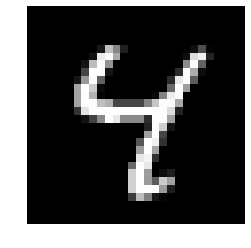

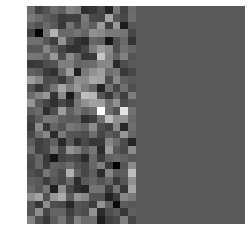

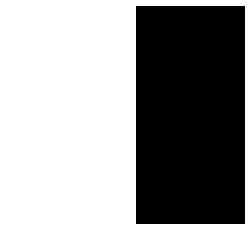

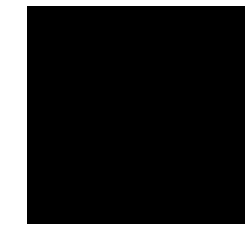

starting search for minima
progress in % 0.0
lrate 0.1
iter 0 loss 86.56891 inverse T 0.2
iter 1000 loss 161.66711 inverse T 0.5
lrate 0.01
iter 0 loss 313.01395 inverse T 1.0
lrate 0.001
iter 0 loss 311.87534 inverse T 1.0
time taken 12.313082695007324


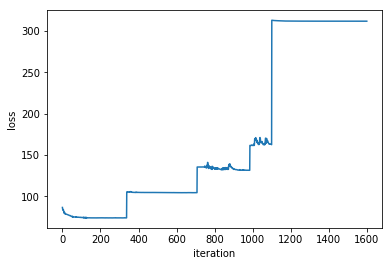

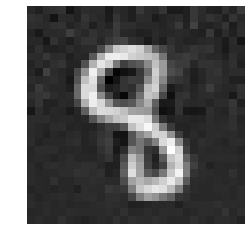

[[-0.15497555 -0.31399307  1.0669369   0.42347446 -1.2496713  -0.4100478
   1.1228383  -0.60017407  0.25277945  0.8127882 ]]
hessian postive definite
progress in % 10.0
lrate 0.1
iter 0 loss 87.62459 inverse T 0.2
iter 1000 loss 158.67552 inverse T 0.5
lrate 0.01
iter 0 loss 304.40723 inverse T 1.0
lrate 0.001
iter 0 loss 304.2309 inverse T 1.0
time taken 11.263373374938965


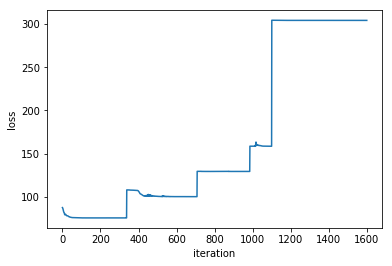

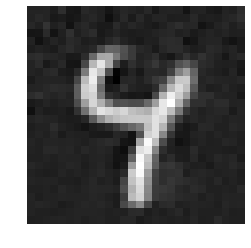

[[-0.26020896  0.38073534 -0.41022104  1.0105224  -1.9619846  -0.39485592
   0.6341232  -1.3844284   0.3402839   0.1768981 ]]
hessian postive definite
progress in % 20.0
lrate 0.1
iter 0 loss 90.62492 inverse T 0.2
iter 1000 loss 175.00984 inverse T 0.5
lrate 0.01
iter 0 loss 339.8741 inverse T 1.0
lrate 0.001
iter 0 loss 339.73895 inverse T 1.0
time taken 11.011464357376099


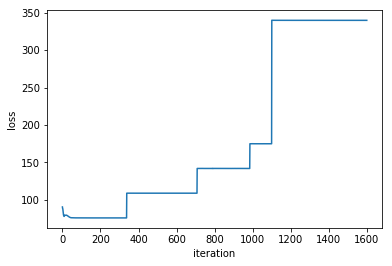

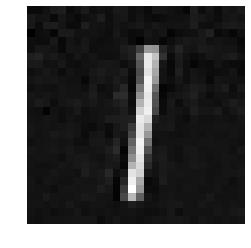

[[-0.19354981  0.4288391   0.76593804  0.28073877 -0.2660083  -0.35428235
   0.01303882  0.48811963 -0.33551088 -0.88986516]]
hessian postive definite
progress in % 30.0
lrate 0.1
iter 0 loss 87.75638 inverse T 0.2
iter 1000 loss 161.55832 inverse T 0.5
lrate 0.01
iter 0 loss 312.17087 inverse T 1.0
lrate 0.001
iter 0 loss 311.8712 inverse T 1.0
time taken 10.47121787071228


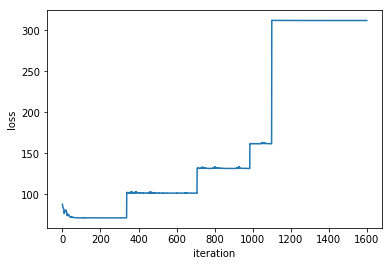

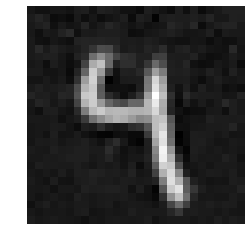

[[-0.53444654 -0.51293427  0.9879566   0.05945762 -0.10398544 -0.07377732
   0.52641124 -1.3543847   0.8319721   0.11445535]]
hessian postive definite
progress in % 40.0
lrate 0.1
iter 0 loss 82.018845 inverse T 0.2
iter 1000 loss 161.88821 inverse T 0.5
lrate 0.01
iter 0 loss 312.16537 inverse T 1.0
lrate 0.001
iter 0 loss 311.8732 inverse T 1.0
time taken 11.091197729110718


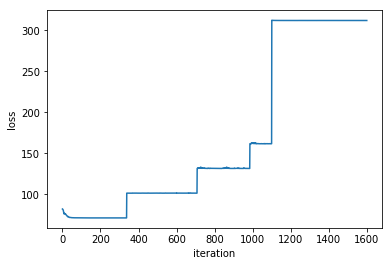

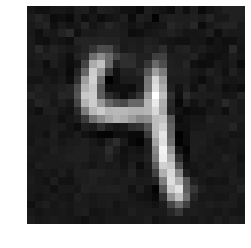

[[-0.5350348  -0.5135459   0.9883485   0.05934711 -0.10403962 -0.07404163
   0.5264579  -1.3544562   0.8317612   0.11482619]]
hessian postive definite
progress in % 50.0
lrate 0.1
iter 0 loss 89.38075 inverse T 0.2
iter 1000 loss 158.67697 inverse T 0.5
lrate 0.01
iter 0 loss 304.67334 inverse T 1.0
lrate 0.001
iter 0 loss 304.3126 inverse T 1.0
time taken 11.2956862449646


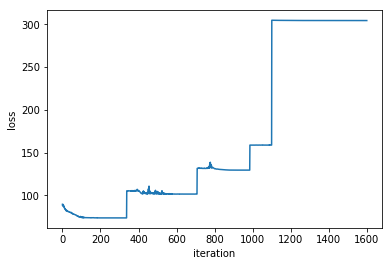

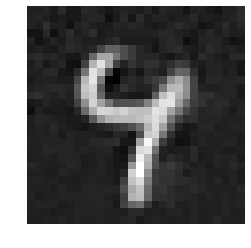

[[ 0.02943627  0.43602023 -0.5243673   0.74939805 -1.9458894  -0.3543505
   0.9370585  -1.3704278   0.281512    0.08567784]]
hessian postive definite
progress in % 60.0
lrate 0.1
iter 0 loss 84.66598 inverse T 0.2
iter 1000 loss 175.01733 inverse T 0.5
lrate 0.01
iter 0 loss 339.81638 inverse T 1.0
lrate 0.001
iter 0 loss 339.73962 inverse T 1.0
time taken 11.096110582351685


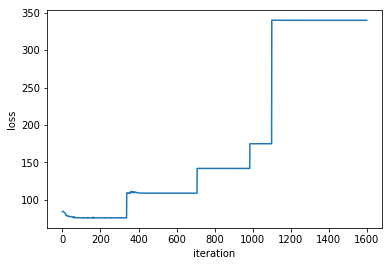

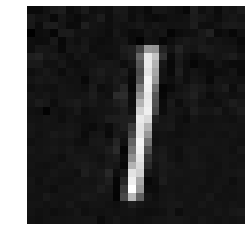

[[-1.8644920e-01  4.2152613e-01  7.5660515e-01  2.7801698e-01
  -2.6561064e-01 -3.6272392e-01 -7.2355405e-04  4.9694893e-01
  -3.3726168e-01 -8.9003587e-01]]
hessian postive definite
progress in % 70.0
lrate 0.1
iter 0 loss 91.73829 inverse T 0.2
iter 1000 loss 158.61974 inverse T 0.5
lrate 0.01
iter 0 loss 304.4286 inverse T 1.0
lrate 0.001
iter 0 loss 304.23114 inverse T 1.0
time taken 10.736321926116943


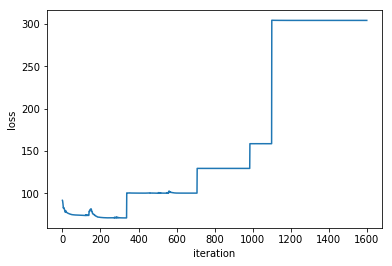

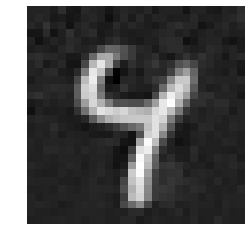

[[-0.26026565  0.38083062 -0.41014087  1.0106142  -1.9620478  -0.39476606
   0.634245   -1.3845389   0.3403529   0.17685123]]
hessian postive definite
progress in % 80.0
lrate 0.1
iter 0 loss 91.76339 inverse T 0.2
iter 1000 loss 162.13145 inverse T 0.5
lrate 0.01
iter 0 loss 305.44342 inverse T 1.0
lrate 0.001
iter 0 loss 304.3571 inverse T 1.0
time taken 10.533259630203247


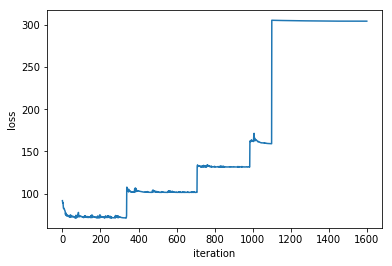

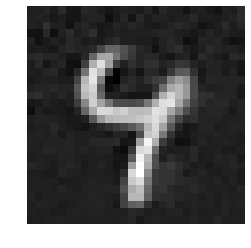

[[ 0.0133394   0.48257348 -0.5991152   0.723976   -1.9428226  -0.32445502
   0.9013575  -1.366099    0.25010458  0.11908284]]
hessian postive definite
progress in % 90.0
lrate 0.1
iter 0 loss 85.3296 inverse T 0.2
iter 1000 loss 174.99069 inverse T 0.5
lrate 0.01
iter 0 loss 339.86697 inverse T 1.0
lrate 0.001
iter 0 loss 339.74503 inverse T 1.0
time taken 10.652498722076416


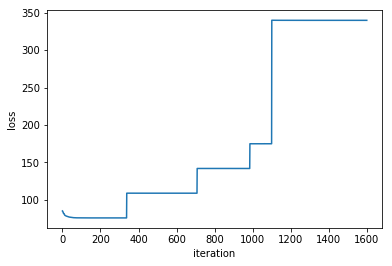

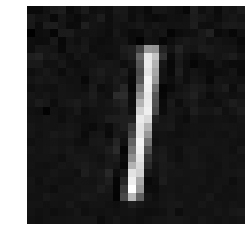

[[-0.1902987   0.42951155  0.7641596   0.27617052 -0.25902402 -0.3561756
   0.01074018  0.4913659  -0.33487946 -0.8877177 ]]
hessian postive definite
analysing the posterior minima:


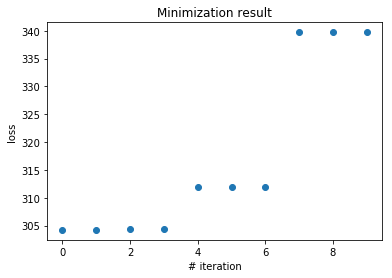

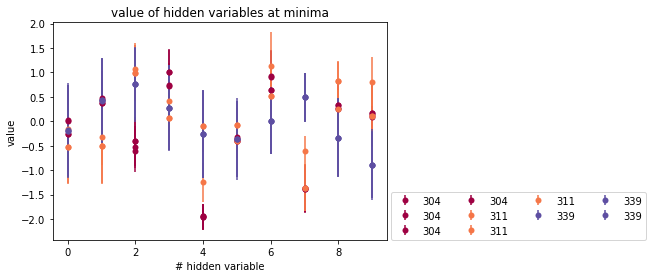

reconstruction from lowest minimum


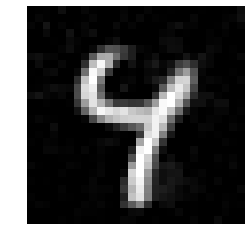

masked reconstruction


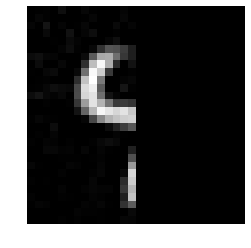

starting stochastic VI on the posterior
lrate 0.001
iter 0 loss [364.44553]
iter 1000 loss [314.91864]
iter 2000 loss [315.22012]
iter 3000 loss [315.40253]
lrate 0.0001
iter 0 loss [314.9166]
iter 1000 loss [315.14142]
lrate 1e-05
iter 0 loss [315.1457]
time taken 129.07305002212524


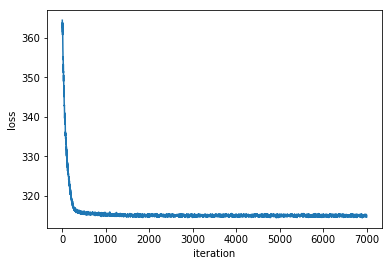

lrate 0.001
iter 0 loss [392.1004]
iter 1000 loss [320.15265]
iter 2000 loss [316.37735]
iter 3000 loss [315.56442]
iter 4000 loss [311.12775]
lrate 0.0001
iter 0 loss [310.75754]
iter 1000 loss [310.67578]
iter 2000 loss [310.5462]
lrate 1e-06
iter 0 loss [310.6961]
iter 1000 loss [310.6805]
time taken 185.34911704063416


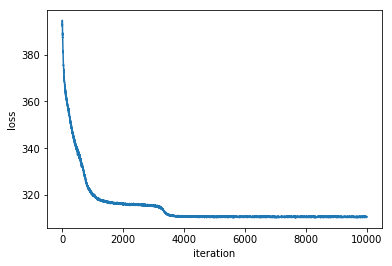

full rank reconstruction


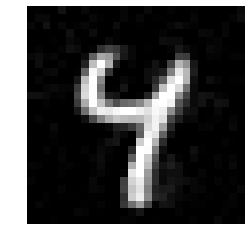

mean field reconstruction


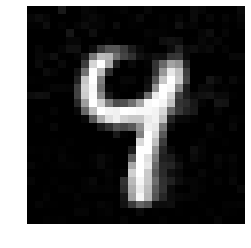

samples from Laplace approximation around deepest minimum (EL2O)


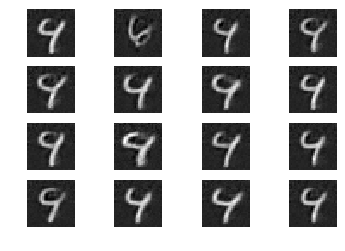

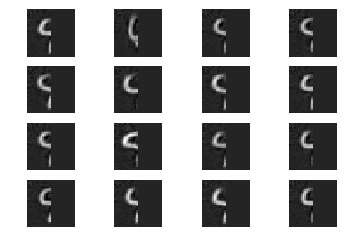

weights of Gaussian mixtures: [[9.9517381e-01]
 [4.8262030e-03]
 [1.2126811e-12]]
samples from Gaussian mixture model (EL2O)


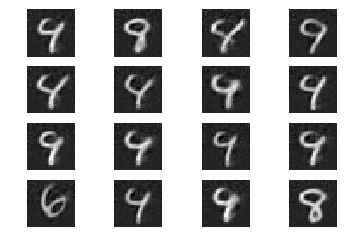

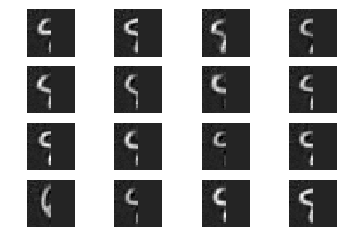

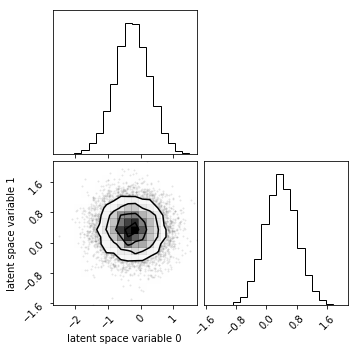

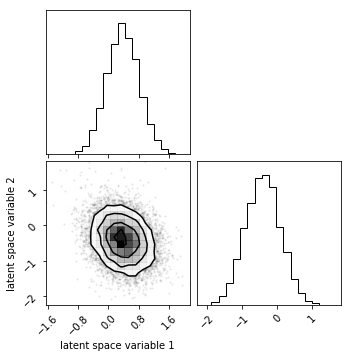

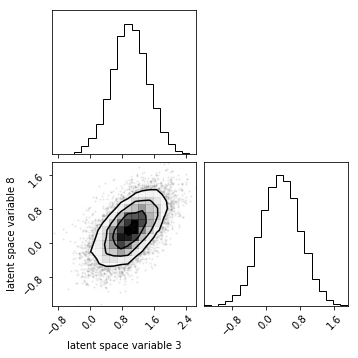

probing the postrior...
[[ 0.35592958  0.48388115  0.17217307  1.3107345  -1.5813934  -0.87867516
   1.8030049  -1.3423384   0.36180833  0.4919712 ]]
[[-0.26026565  0.38083062 -0.41014087  1.0106142  -1.9620478  -0.39476606
   0.634245   -1.3845389   0.3403529   0.17685123]]
304.2308 305.81714 306.13754
57.32655477481124 265.36533
9.894808101901589 26.428526
118.1375164729816 97.2289


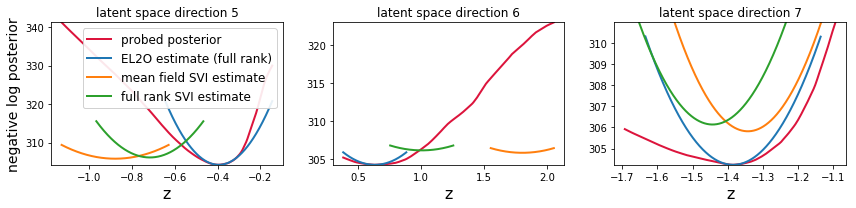

In [315]:
if __name__ == "__main__":
  sess = tf.Session()
  sess.run(tf.global_variables_initializer())
  
  # underlying truth
  truth = x_test[num_mnist:num_mnist+data_size]
  plot_image(truth, directory=plot_path, filename='truth_%s'%label, title='truth')
  
  # corrupted data
  data, custom_mask = make_corrupted_data(truth, corr_type=corr_type)
  plot_image(data, directory=plot_path, filename='input_data_%s'%label, title='data')
  plot_image(custom_mask, directory=plot_path, filename='mask_data_%s'%label, title='mask')
  
  # noise
  noise = get_custom_noise(data.shape, signal_dependent=False, signal=truth)
  plot_image(noise, directory=plot_path, filename='noise_%s'%label, title='noise')
  
 
  tf.random.set_random_seed(seed)
  inits = get_random_start_values(10, sess)
  
  # find minima
  print('starting search for minima')
  try:
    assert(False)
    minima, min_loss, min_var, recons = pickle.load(open(minima_path+'minima_%s.pkl'%label,'rb'))
    print('loaded saved minima')
  except:
  
    minima  =[]
    min_loss=[]
    min_var =[]
    recons  =[]
    for jj,init in enumerate(inits):
      print('progress in %', jj/len(inits)*100)
      min_z, min_l, pos_def    = minimize_posterior(init, data,custom_mask,noise,sess)
      rec                      = sess.run(recon_MAP, feed_dict={sigma_corr:noise})
      var                      = sess.run(variance, feed_dict={input_data: data,mask:custom_mask,sigma_corr:noise})
  
      plot_image(rec, directory=plot_path, filename='recon_%s_minimum%d'%(label,jj), title='reconstruction with loss %.1f'%min_l)
      print(min_z)
      if pos_def:
        print('hessian postive definite')
        minima.append(min_z)
        min_loss.append(min_l)
        min_var.append(var)
        recons.append(rec)
    
    order    = np.argsort(min_loss)
    min_loss = np.asarray(min_loss)[order]
    minima   = np.asarray(minima)[order]
    min_var  = np.asarray(min_var)[order]
    
    pickle.dump([minima, min_loss, min_var,recons],open(minima_path+'minima_%s.pkl'%label,'wb'))

  print('analysing the posterior minima:')
  plot_minima(minima, min_loss, min_var)
  
  # set MAP value to lowest minimum
  lowest_minimum = sess.run(MAP_reset, feed_dict={MAP_ini:minima[0]})
  # and plot
  print('reconstruction from lowest minimum')
  rec     = sess.run(recon_MAP, feed_dict={sigma_corr:noise})
  plot_image(rec, directory=plot_path, filename='lowest_minimum_%s'%(label), title='reconstruction', vmin=0, vmax=1)
  if corr_type in ['mask', 'sparse mask', 'noise+mask']:
    print('masked reconstruction')
    plot_image(rec, directory=plot_path, filename='lowest_minimum_%s_masked'%(label), title='masked reconstruction', vmin=0, vmax=1, mask = custom_mask)
    
    
  print('starting stochastic VI on the posterior')
  sess.run(update_mu_elbo, feed_dict={input_data: data,mask:custom_mask,sigma_corr:noise})
  minimize_neg_elbo(data,custom_mask,noise,sess)
  minimize_neg_elbo(data,custom_mask,noise,sess, full_rank=True)  
  
  print('full rank reconstruction')
  rec     = sess.run(recon_fr, feed_dict={sigma_corr:noise})
  plot_image(rec, directory=plot_path, filename='full_rank_VI_%s'%(label), title='reconstruction', vmin=0, vmax=1)
  print('mean field reconstruction')
  rec     = sess.run(recon_elbo, feed_dict={sigma_corr:noise})
  plot_image(rec, directory=plot_path, filename='mean_field_VI_%s'%(label), title='reconstruction', vmin=0, vmax=1)
    


  print('samples from Laplace approximation around deepest minimum (EL2O)')
  samples = get_laplace_sample(16,minima[0],data,custom_mask,noise,sess)
  plot_samples(samples, custom_mask, title='Samples from Laplace approximation', filename='samples_laplace_deepest_minimum_%s'%label)  
  
  # here, the separate minima have to be set by hand
  mu_, sigma_, w_ = get_gmm_parameters([minima[0],minima[4],minima[7]], data, noise, custom_mask, min_loss[0])
  _ = sess.run([update_w, update_mugmm,update_TriLgmm], feed_dict={mu_ini:mu_, w_ini:w_, sigma_ini:sigma_ })
  
  
  
  samples = get_gmm_sample(16,data,custom_mask,noise,sess)
  print('samples from Gaussian mixture model (EL2O)')
  plot_samples(samples, custom_mask, title='GMM samples', filename='gmm_samples_%s'%label)
  
  more_samples = []
  for ii in range(10000):
    more_samples+=[sess.run(gmm_sample,feed_dict={input_data: data, sigma_corr:noise})]
  more_samples=np.asarray(more_samples)
  
  for indices in [[0,1],[1,2],[3,8]]:
    plot_prob_2D_GMM(more_samples, indices)
    
  print('probing the postrior...')
  probe_posterior(minima[0], data, noise, custom_mask, sess)
  
  
